In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import ast, os, gc, pdb, random, time

from fastai.callback.all import *
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, IndexSplitter, RegressionBlock
from fastai.imports import *
from fastai.layers import SigmoidRange
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat, MSELossFlat, LabelSmoothingCrossEntropyFlat
from fastai.optimizer import Adam
from fastai.metrics import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.transform import Transform
from sklearn.model_selection import train_test_split
from torch.utils.checkpoint import checkpoint
from transformers import (
    AutoConfig,
    AutoModelForNextSentencePrediction,
    AutoModelForSequenceClassification,
    DebertaV2Model,
    logging,
)
from transformers.models.deberta_v2.modeling_deberta_v2 import ContextPooler
from transformers.models.deberta_v2.modeling_deberta_v2 import StableDropout

from blurr.callbacks import GradientCheckpointing
from blurr.text.data.core import TextBlock, BatchTokenizeTransform
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss, PreCalculatedMSELoss, set_seed

# silence all the HF warnings
warnings.simplefilter("ignore")
logging.set_verbosity_error()
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
gpu_num = 0

torch.cuda.set_device(gpu_num)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #0: GeForce GTX 1080 Ti


In [4]:
random_seed = 2022
val_pct = 0.25
bsz = 8
data_subset_pct = 1.0

# HF objects
model_checkpoint = "microsoft/deberta-v3-small"
model_cls = AutoModelForSequenceClassification

# model_checkpoint = "bert-base-uncased"
# model_cls = AutoModelForNextSentencePrediction

## Data

In [5]:
raw_train_df = pd.read_csv("../../data/clean/segmentation_train.csv", index_col=None)
raw_train_df["other_topic_seqs"] = raw_train_df["other_topic_seqs"].apply(ast.literal_eval)
raw_train_df.reset_index(inplace=True)

print(len(raw_train_df))
raw_train_df.head()

25383


,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,0,C-Squared Podcast,1,Intro,[Music] welcome everybody to episode one of a,chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up,False,NaN,"[christian well not so much fabi uh it's first of all great um to finally start a, podcast the chess podcast i know that um there's a lot of podcasts out there but, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to m..."
1,1,C-Squared Podcast,1,Intro,chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up,christian well not so much fabi uh it's first of all great um to finally start a,False,NaN,"[[Music] welcome everybody to episode one of a, podcast the chess podcast i know that um there's a lot of podcasts out there but, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention the location because, those ..."
2,2,C-Squared Podcast,1,Intro,christian well not so much fabi uh it's first of all great um to finally start a,podcast the chess podcast i know that um there's a lot of podcasts out there but,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, i wanted to bring our own tune to the mix and i think uh yeah i'm, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention the location beca..."
3,3,C-Squared Podcast,1,Intro,podcast the chess podcast i know that um there's a lot of podcasts out there but,i wanted to bring our own tune to the mix and i think uh yeah i'm,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, christian well not so much fabi uh it's first of all great um to finally start a, excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, also a bit difficult at times my home uh here we are not going to mention th..."
4,4,C-Squared Podcast,1,Intro,i wanted to bring our own tune to the mix and i think uh yeah i'm,excited about that so that's uh the first thing how about yourself fabian well i'm back in the states after it's,False,NaN,"[[Music] welcome everybody to episode one of a, chess themed podcast with myself christian kirilla and i'm fighting on caruana so what's up, christian well not so much fabi uh it's first of all great um to finally start a, podcast the chess podcast i know that um there's a lot of podcasts out there but, been a while at your home it's good to be here it's my first time in uh visiting here and uh, yeah it's been an interesting few months played a lot of chess which is pretty cool but, als

In [6]:
raw_train_df["seq"].sample(n=1).values[0].strip()

"one starting point is you can what's called canary the model which means that instead of instead of"

### Train Eval split

For training we need to remove sequences for which there is not a "next_seq" (e.g., we are at end of a topic)

In [7]:
train_df = raw_train_df[raw_train_df["is_topic_end"] == False].copy()
print(len(train_df))

24786


Validation set should ideally ***not*** include courses in the training set

In [8]:
# if we were just concerned with creating a validation set and nothing else
# _, val_idxs = train_test_split(range(len(train_df)), test_size=val_pct, random_state=random_seed)


# shuffle dataset - optional subset for faster iteration
train_df = train_df.sample(frac=data_subset_pct, random_state=random_seed).reset_index(drop=True)

courses = train_df["course_title"].unique()

np.random.seed(random_seed)
np.random.shuffle(courses)

val_sz = int(len(courses) * val_pct)
val_courses = courses[:val_sz]

is_val = np.isin(train_df["course_title"], val_courses)

idxs = np.arange(len(train_df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]

## HF objects

In [9]:
if random_seed:
    set_seed(random_seed)

    # need to create configuration object separately because we may be adding new attributes (e.g., cls_dropout)
    hf_config = AutoConfig.from_pretrained(model_checkpoint)
    hf_config.update({})

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        model_checkpoint,
        model_cls=model_cls,
        config=hf_config,
        tokenizer_kwargs={},
        model_kwargs={},
    )

## DataLoaders

In [10]:
class SiameseBatchTokenizeTransform(BatchTokenizeTransform):
    def __init__(self, use_next_pos_prob=0.75, use_adjacent_neg_prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.use_next_pos_prob = use_next_pos_prob
        self.use_adjacent_neg_prob = use_adjacent_neg_prob

    def encodes(self, samples, return_batch_encoding=False):
        # our positive example
        pos_ex_idx = 0 if random.uniform(0, 1) < self.use_next_pos_prob else 1
        updated_samples1, inputs1 = super().encodes(
            [(s[0][pos_ex_idx] if s[0][pos_ex_idx] != "xxNONExx" else s[0][0], *s[2:], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # our negative example (sometimes the adjacent will be ""; if that is the case use the other topic negative example which is at idx=1)
        neg_ex_idx = 0 if random.uniform(0, 1) < self.use_adjacent_neg_prob and pos_ex_idx == 0 else 1
        updated_samples2, inputs2 = super().encodes(
            [(s[1][neg_ex_idx] if s[1][neg_ex_idx] != "xxNONExx" else s[1][1], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # if there are no targets (e.g., when used for inference)
        if len(samples[0]) == 2:
            return [(inps1[0], inps2[0]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

        return [(inps1[0], inps2[0], inps1[-1]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

In [11]:
def build_pos_inputs(example, tok_sep_token="[SEP]", lower_case=True):
    seq_text = example["seq"].strip().lower() if lower_case else example["seq"].strip()
    next_seq_text = example["next_seq"].strip().lower() if lower_case else example["next_seq"].strip()

    non_adjacent_text = (
        random.choice(example["other_topic_seqs"]).strip() if len(example["other_topic_seqs"]) > 0 else None
    )
    if lower_case and non_adjacent_text:
        non_adjacent_text = non_adjacent_text.lower()

    if example["is_topic_end"] and example["next_topic_begin_seq"] and non_adjacent_text:
        # this is the last sequence in the topic so the only thing that will work here is to pair it with another non-adjacent seq in the same topic
        # and therefore we just duplicate it here.
        next_topic_begin_seq = (
            example["next_topic_begin_seq"].strip().lower() if lower_case else example["next_topic_begin_seq"].strip()
        )
        inp = (f"{seq_text}{tok_sep_token}{non_adjacent_text}", f"{seq_text}{tok_sep_token}{non_adjacent_text}")
    else:
        # the positive pair will be a seq + the next seq -or- the seq + a non-adjacent seq in the same topic
        inp = (
            f"{seq_text}{tok_sep_token}{next_seq_text}",
            f"{seq_text}{tok_sep_token}{non_adjacent_text}" if non_adjacent_text else "xxNONExx",
        )

    return inp

In [12]:
def build_neg_inputs(example, tok_sep_token="[SEP]", lower_case=True):
    seq_text = example["seq"].strip()

    # if at the last sequence for a topic, set the negative pair = seq + first sequence in next topic,
    # else get a sequence that is not adjacent but in same topic
    if example["is_topic_end"] and example["next_topic_begin_seq"]:
        neg_seq_non_adjacent_text = example["next_topic_begin_seq"].strip()
    elif len(example["other_topic_seqs"]) > 0:
        neg_seq_non_adjacent_text = random.choice(example["other_topic_seqs"]).strip()
    else:
        neg_seq_non_adjacent_text = "xxNONExx"

    # get a sequence that is in an entirely different topic
    # option 1: can be in same lesson but different topic or in a different course entirely
    # neg_seq_other_topic_text = (
    #     train_df["seq"][
    #         (train_df["course_title"] != example["course_title"]) | (train_df["lesson_num"] != example["lesson_num"])
    #     ]
    #     .sample(n=1)
    #     .values[0]
    #     .strip()
    # )

    # option 2: sample from a different course entirely
    neg_seq_other_topic_text = (
        train_df["seq"][(train_df["course_title"] != example["course_title"])].sample(n=1).values[0].strip()
    )

    if lower_case:
        seq_text = seq_text.lower()
        neg_seq_non_adjacent_text = neg_seq_non_adjacent_text.lower()
        neg_seq_other_topic_text = neg_seq_other_topic_text.lower()

    # our SiameseBatchTokenizeTransform will choose which one to use each time the item is fetched
    inp = (
        f"{seq_text}{tok_sep_token}{neg_seq_non_adjacent_text}",
        f"{seq_text}{tok_sep_token}{neg_seq_other_topic_text}",
    )

    return inp

In [13]:
def build_targets(example):
    return 0

In [14]:
def get_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs, get_x=None):
    # define validation set
    splitter = IndexSplitter(val_idxs)

    if random_seed:
        set_seed(random_seed)

    batch_tokenize_tfm = SiameseBatchTokenizeTransform(
        use_adjacent_neg_prob=0.75,
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        include_labels=False,
        max_length=True,
        truncation=True,
        tok_kwargs={},
    )

    blocks = (TextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop, CategoryBlock)

    get_pos_x = partial(build_pos_inputs, tok_sep_token=hf_tokenizer.sep_token, lower_case=True)
    get_neg_x = partial(build_neg_inputs, tok_sep_token=hf_tokenizer.sep_token, lower_case=True)
    get_y = partial(build_targets)

    dblock = DataBlock(
        blocks=blocks,
        get_x=[get_pos_x, get_neg_x],
        get_y=get_y,
        splitter=splitter,
        n_inp=2,
    )

    if random_seed:
        set_seed(random_seed)

    return dblock.dataloaders(df, bs=bsz, val_bs=bsz * 2)

In [15]:
dls = get_dls(train_df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs=val_idxs)

In [16]:
b = dls.one_batch()

In [17]:
len(b)

3

In [18]:
hf_tokenizer.decode(b[0]["input_ids"][0])

"[CLS] and in fact in this case they actually have scores, it's either going to be, basically, zero (0), zero point two five (0.25), point five (0.5), point seven five (0.75), or one (1), of,[SEP] like, how similar is it. but it's basically a classification task, when you think of it that way. so yeah, you can have a look at the data and, next week, we're going to go through step[SEP][PAD][PAD][PAD][PAD][PAD][PAD]"

In [19]:
hf_tokenizer.decode(b[1]["input_ids"][0])

"[CLS] and in fact in this case they actually have scores, it's either going to be, basically, zero (0), zero point two five (0.25), point five (0.5), point seven five (0.75), or one (1), of,[SEP] all right, thanks, everybody. i'll see you next week. bye.[SEP]"

In [20]:
b[2]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

## Models

In [21]:
def blurr_splitter_with_head(m: Module):
    """Simply adds an additional layer group to the classification head"""
    base_param_groups = blurr_splitter(m)

    added_groups = L([m for m_name, m in list(m.named_children()) if m_name != "hf_model"])
    added_param_groups = added_groups.map(params).filter(lambda el: len(el) > 0)

    return base_param_groups + added_param_groups


def blurr_splitter_on_backbone(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    root_modules = list(m.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L(top_module)
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [22]:
# TODO: Review PyTorch docs (https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html); consider changing
def MarginRankingLoss(pos_neg_scores, targs):
    margin = 1
    p_scores, n_scores = pos_neg_scores

    scores = margin - p_scores + n_scores
    scores = scores.clamp(min=0)
    return scores.mean()

In [23]:
def f1_score(inps, targs):
    labels = []
    all_pos_scores, all_neg_scores = inps[0], inps[1]

    for i in range(len(all_pos_scores)):
        if all_pos_scores[i] > all_neg_scores[i]:
            labels.append(1)
        else:
            labels.append(0)

    return sum(labels) / float(len(all_pos_scores))


_f1_score = AvgMetric(f1_score)

In [24]:
class TopicSegmentationModelWrapper(BaseModelWrapper):
    def __init__(
        self,
        hf_config,
        hf_model,
        dropout_cls=nn.Dropout,
        p=0.1,
        hf_model_kwargs={},
    ):
        super().__init__(hf_model=hf_model, output_hidden_states=True, hf_model_kwargs=hf_model_kwargs)
        store_attr()

        self.coherence_prediction_dec = nn.Sequential(
            *[
                nn.Linear(hf_config.hidden_size, hf_config.hidden_size),
                nn.ReLU(),
                dropout_cls(p=p),
                nn.Linear(hf_config.hidden_size, 2),
            ]
        )

    def forward(self, inputs1, inputs2):
        # sequence 1 (pos examples)
        inputs1_res = super().forward(inputs1)
        pos_scores = inputs1_res.hidden_states[-1][:, 0, :]
        pos_scores = self.coherence_prediction_dec(pos_scores)

        # sequence 2 (neg examples)
        inputs2_res = super().forward(inputs2)
        neg_scores = inputs2_res.hidden_states[-1][:, 0, :]
        neg_scores = self.coherence_prediction_dec(neg_scores)

        return pos_scores[:, 0], neg_scores[:, 0]

In [25]:
if random_seed:
    set_seed(random_seed)

learn_cbs = []
fit_cbs = [GradientClip(max_norm=1.0)]

blurr_model_wrapper = TopicSegmentationModelWrapper(hf_config=hf_config, hf_model=hf_model)

learn = Learner(
    dls,
    blurr_model_wrapper,
    loss_func=MarginRankingLoss,
    metrics=[_f1_score],
    cbs=learn_cbs,
    splitter=blurr_splitter_on_backbone,
)

learn.create_opt()
learn.freeze()
learn = learn.to_fp16()

In [26]:
print(len(learn.opt.param_groups))

2


SuggestedLRs(minimum=0.0033113110810518267, steep=0.02290867641568184, valley=0.010964781977236271, slide=0.0014454397605732083)

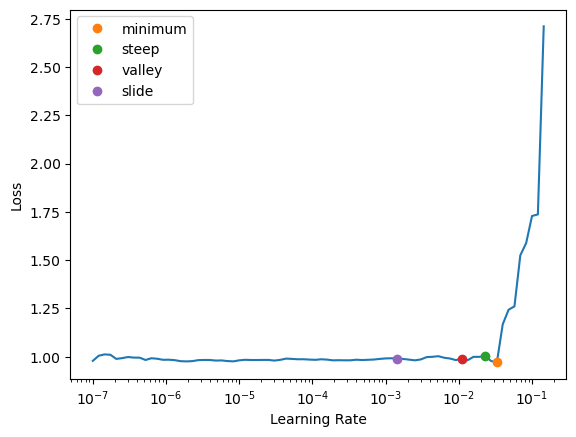

In [27]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [28]:
if random_seed:
    set_seed(random_seed)

learn.fit_one_cycle(4, slice(1e-5, 1e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,f1_score,time
0,0.420839,0.587762,0.759843,06:06
1,0.325482,0.472662,0.808081,06:08
2,0.278993,0.411808,0.825397,06:12
3,0.266935,0.388746,0.840858,06:10


In [29]:
r = learn.recorder
r.metric_names, r.values

((#5) ['epoch','train_loss','valid_loss','f1_score','time'],
 [(#3) [0.4208391308784485,0.5877618193626404,0.7598433312719027],
  (#3) [0.325481653213501,0.4726616442203522,0.8080808080808081],
  (#3) [0.27899280190467834,0.41180819272994995,0.8253968253968254],
  (#3) [0.26693519949913025,0.38874563574790955,0.8408575551432694]])

In [30]:
learn.export("topic_segmentation_learner.pkl")

## Inference

In [31]:
raw_train_df.course_title.unique().tolist()

['C-Squared Podcast',
 'Full Stack Deep Learning - Spring 2021',
 'ali - how to start a business',
 'cc - how to invest in stocks',
 'dr berg - adrenal body type',
 'dr berg - cereal vid',
 'dr berg - diabetes myth',
 'dr berg - how to fast',
 'dr berg - what happens when you fast',
 'fast.ai 2022 - Part 1',
 'markowskyart - begginer drawing course',
 'parker - learn photography']

In [98]:
train_df.iloc[val_idxs]["course_title"].unique()

array(['markowskyart - begginer drawing course',
       'cc - how to invest in stocks', 'dr berg - cereal vid'],
      dtype=object)

In [99]:
# val_course_title = random.choice(train_df.iloc[val_idxs]["course_title"].unique().tolist())
# print(val_course_title)
# val_lesson_num = "1"

val_course_title = "fast.ai 2022 - Part 1"
val_lesson_num = "4"

In [100]:
inf_df = raw_train_df[
    (raw_train_df["course_title"] == val_course_title) & (raw_train_df["lesson_num"] == val_lesson_num)
].copy()
inf_df.reset_index(inplace=True)

print(len(inf_df))
inf_df.head()

709


,level_0,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,15307,15307,fast.ai 2022 - Part 1,4,Using Huggingface,"Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think","is the lesson that a lot of the regulars in the community have been most excited about,",False,NaN,"[because it's where we're gonna get some totally new material — totally new topic, we've, never covered before. We're going to cover natural language processing (NLP), and you'll, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, doi..."
1,15308,15308,fast.ai 2022 - Part 1,4,Using Huggingface,"is the lesson that a lot of the regulars in the community have been most excited about,","because it's where we're gonna get some totally new material — totally new topic, we've",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, never covered before. We're going to cover natural language processing (NLP), and you'll, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, ..."
2,15309,15309,fast.ai 2022 - Part 1,4,Using Huggingface,"because it's where we're gonna get some totally new material — totally new topic, we've","never covered before. We're going to cover natural language processing (NLP), and you'll",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, is the lesson that a lot of the regulars in the community have been most excited about,, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, d..."
3,15310,15310,fast.ai 2022 - Part 1,4,Using Huggingface,"never covered before. We're going to cover natural language processing (NLP), and you'll","find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, is the lesson that a lot of the regulars in the community have been most excited about,, because it's where we're gonna get some totally new material — totally new topic, we've, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, doing today is we're going to be fine-tuning a pre-trained NLP model using a library call..."
4,15311,15311,fast.ai 2022 - Part 1,4,Using Huggingface,"find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the","fast.ai library, using recurrent neural networks (RNNs).",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, is the le

In [101]:
inf_learn = load_learner("topic_segmentation_learner.pkl")
inf_learn.model.hf_model = inf_learn.model.hf_model.eval()

In [102]:
seq_pairs = L()

for i in range(len(inf_df) - 1):
    seq_a = inf_df.iloc[i]["seq"].strip().lower()
    seq_b = inf_df.iloc[i + 1]["seq"].strip().lower()

    seq_pairs.append((seq_a, seq_b))

In [103]:
scores = []

for i in range(0, len(seq_pairs), 16):
    # print(i)
    batch = seq_pairs[i : i + 16]
    inputs = hf_tokenizer(
        list(batch.itemgot(0)), list(batch.itemgot(1)), padding=True, max_length=True, return_tensors="pt"
    )

    batch_scores = inf_learn.model.hf_model(**inputs)
    scores += batch_scores[0][:, 0].detach().cpu()[:, None]

In [104]:
scores = torch.sigmoid(torch.concat(scores)).numpy().tolist()

In [105]:
import statistics, segeval
from sklearn.metrics import mean_absolute_error, f1_score, recall_score, precision_score, fbeta_score

In [106]:
def depth_score_cal(scores):
    output_scores = []
    for i in range(len(scores)):
        lflag = scores[i]
        rflag = scores[i]
        if i == 0:
            hl = scores[i]
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
        elif i == len(scores):
            hr = scores[i]
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        else:
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        depth_score = 0.5 * (lflag + rflag - 2 * scores[i])
        output_scores.append(depth_score)

    return output_scores

In [107]:
depth_scores = depth_score_cal(scores)
print(depth_scores[:10])

[0.001102358102798462, 0.001096278429031372, 0.0, 0.0017909705638885498, 0.00334717333316803, 0.0, 0.0002167820930480957, 0.0027249157428741455, 0.0008751749992370605, 0.0]


In [108]:
print(sum(depth_scores) / (len(depth_scores)))
print(statistics.stdev(depth_scores) * 0.1)

0.0018276203486878994
0.0002057399657654498


In [137]:
threshold = sum(depth_scores) / (len(depth_scores)) + (statistics.stdev(depth_scores) * 1.5)
print(threshold)

0.004913719835169646


In [138]:
len(depth_scores)

708

In [139]:
boundary_indice = []
seg_p_labels = [0] * (len(depth_scores) + 1)

for i in range(len(depth_scores)):
    if depth_scores[i] > threshold:
        boundary_indice.append(i)

for i in boundary_indice:
    seg_p_labels[i] = 1


tmp = 0
seg_p = []
for idx, fake in enumerate(seg_p_labels):
    if fake == 1 and idx != 0:
        # tmp += 1
        seg_p.append(tmp)
        tmp = 1
    else:
        tmp += 1
seg_p.append(tmp)

In [140]:
print(len(seg_p_labels))
print(seg_p_labels[:20])
print("")

total = 0
for el in seg_p:
    total += el

print(len(seg_p))
print(seg_p)
print(total)

709
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

68
[24, 23, 7, 13, 2, 21, 2, 9, 4, 6, 29, 4, 4, 4, 2, 5, 11, 1, 47, 28, 3, 15, 5, 36, 28, 37, 6, 2, 3, 4, 1, 1, 4, 1, 6, 28, 7, 9, 3, 15, 2, 6, 4, 13, 23, 14, 3, 17, 21, 9, 4, 15, 2, 3, 2, 6, 4, 24, 18, 5, 4, 7, 8, 7, 9, 2, 3, 14]
709


In [141]:
seg_r_labels = []
seg_r = []
tmp = 1

for r_idx, r in inf_df.iterrows():
    current_topic = r["topic"]
    if r_idx == 0:
        last_seen_topic = r["topic"]

    if last_seen_topic != current_topic:
        last_seen_topic = current_topic
        seg_r_labels.append(1)
        seg_r.append(tmp)
        tmp = 1
    else:
        seg_r_labels.append(0)
        tmp += 1 if r_idx != 0 else 0

seg_r.append(tmp)

In [142]:
print(len(seg_r))
print(seg_r[:30])
print(seg_r[-30:])
print("")
print(len(seg_r_labels))
print(seg_r_labels[:30])
print(seg_r_labels[-30:])
print("")
total = 0
for el in seg_r:
    total += el
print(total)

29
[27, 15, 29, 12, 31, 11, 37, 28, 34, 31, 25, 18, 18, 16, 17, 37, 12, 38, 16, 17, 20, 47, 27, 39, 19, 24, 5, 47, 12]
[27, 15, 29, 12, 31, 11, 37, 28, 34, 31, 25, 18, 18, 16, 17, 37, 12, 38, 16, 17, 20, 47, 27, 39, 19, 24, 5, 47, 12]

709
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

709


In [143]:
print(len(seg_r), len(seg_p))

score_wd = segeval.window_diff(seg_p, seg_r)
print(score_wd)

score_pk = segeval.pk(seg_p, seg_r)
print(score_pk)

29 68
0.6829268292682926829268292683
0.5423242467718794835007173601


In [144]:
print(len(seg_r_labels), len(seg_p_labels))
print(seg_r_labels[:20])
print(seg_p_labels[:20])
print("")
print(seg_r_labels[-20:])
print(seg_p_labels[-20:])

709 709
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [145]:
print(len(seg_r_labels), len(seg_p_labels))

score_mae = sum(list(map(abs, np.array(seg_r_labels) - np.array(seg_p_labels))))
print(score_mae)

print(f1_score(seg_r_labels, seg_p_labels, average="macro"))
print(fbeta_score(seg_r_labels, seg_p_labels, beta=2, average="macro"))
print(precision_score(seg_r_labels, seg_p_labels, average="macro"))
print(recall_score(seg_r_labels, seg_p_labels, average="macro"))

709 709
87
0.5092254445637904
0.5148677043189036
0.51115915748361
0.5251730648206419


In [147]:
seg_idxs = [seg_idx for seg_idx, v in enumerate(seg_p_labels) if v == 1 or seg_idx == 0]
print(len(seg_idxs))
print(seg_idxs[:40])

68
[0, 24, 47, 54, 67, 69, 90, 92, 101, 105, 111, 140, 144, 148, 152, 154, 159, 170, 171, 218, 246, 249, 264, 269, 305, 333, 370, 376, 378, 381, 385, 386, 387, 391, 392, 398, 426, 433, 442, 445]


In [133]:
inf_df["pred_start"] = False

In [134]:
inf_df.loc[seg_idxs, "pred_start"] = True

In [135]:
pd.set_option("display.max_rows", None)

In [136]:
inf_df

,level_0,index,course_title,lesson_num,topic,seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs,pred_start
0,15307,15307,fast.ai 2022 - Part 1,4,Using Huggingface,"Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think","is the lesson that a lot of the regulars in the community have been most excited about,",False,NaN,"[because it's where we're gonna get some totally new material — totally new topic, we've, never covered before. We're going to cover natural language processing (NLP), and you'll, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, doi...",True
1,15308,15308,fast.ai 2022 - Part 1,4,Using Huggingface,"is the lesson that a lot of the regulars in the community have been most excited about,","because it's where we're gonna get some totally new material — totally new topic, we've",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, never covered before. We're going to cover natural language processing (NLP), and you'll, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, ...",False
2,15309,15309,fast.ai 2022 - Part 1,4,Using Huggingface,"because it's where we're gonna get some totally new material — totally new topic, we've","never covered before. We're going to cover natural language processing (NLP), and you'll",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, is the lesson that a lot of the regulars in the community have been most excited about,, find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, d...",False
3,15310,15310,fast.ai 2022 - Part 1,4,Using Huggingface,"never covered before. We're going to cover natural language processing (NLP), and you'll","find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think, is the lesson that a lot of the regulars in the community have been most excited about,, because it's where we're gonna get some totally new material — totally new topic, we've, fast.ai library, using recurrent neural networks (RNNs)., Today we're going to do something else, which is we're going to do Transformers, and we're, not even going to use the fast.ai library at all in fact. So, what we're going to be, doing today is we're going to be fine-tuning a pre-trained NLP model using a library call...",False
4,15311,15311,fast.ai 2022 - Part 1,4,Using Huggingface,"find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the","fast.ai library, using recurrent neural networks (RNNs).",False,NaN,"[Hi everybody, and welcome to Practical Deep Learning for Coders Les

In [ ]:
inf_learner = load_learner("topic_segmentation_learner.pkl")
inf_dl = inf_learner.dls.test_dl(inf_df)

In [ ]:
for idx, b in enumerate(inf_dl):
    print(hf_tokenizer.decode(b[0]["input_ids"][0]))
    print(hf_tokenizer.decode(b[1]["input_ids"][0]))
    print("---")
    print(hf_tokenizer.decode(b[0]["input_ids"][1]))
    print(hf_tokenizer.decode(b[1]["input_ids"][1]))
    print("---")
    print(hf_tokenizer.decode(b[0]["input_ids"][2]))
    print(hf_tokenizer.decode(b[1]["input_ids"][2]))
    print("---")
    print(len(b[0]["input_ids"]))

    scores = inf_learner.model.hf_model(b[0]["input_ids"], attention_mask=b[0]["attention_mask"])
    print(scores)
    print(torch.sigmoid(scores[0][:, 0]).detach().cpu().numpy().tolist())
    if idx == 0:
        break

In [ ]:
preds, _ = inf_learner.get_preds(dl=inf_dl)

In [ ]:
print(len(preds), len(preds[0]), len(preds[1]))
print(preds[0][:5])
print(preds[1][:5])

In [ ]:
import statistics, segeval
from sklearn.metrics import mean_absolute_error, f1_score, recall_score, precision_score

In [ ]:
scores = torch.sigmoid(preds[0]).detach().cpu().numpy().tolist()

print(len(scores))
print(scores[:10])

In [ ]:
scores_np = np.array(scores)
print(scores_np.mean(), scores_np.std())

scores_np.mean() - (0.1 * scores_np.std())

In [ ]:
def depth_score_cal(scores):
    output_scores = []
    for i in range(len(scores)):
        lflag = scores[i]
        rflag = scores[i]
        if i == 0:
            hl = scores[i]
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
        elif i == len(scores):
            hr = scores[i]
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        else:
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        depth_score = 0.5 * (lflag + rflag - 2 * scores[i])
        output_scores.append(depth_score)

    return output_scores

In [ ]:
depth_scores = depth_score_cal(scores)

print(len(depth_scores))
print(depth_scores[:10])

In [ ]:
depth_scores_np = np.array(depth_scores)
depth_scores_np.mean(), depth_scores_np.std(), depth_scores_np.var()

In [ ]:
threshold = sum(depth_scores) / (len(depth_scores)) - 0.1 * statistics.stdev(depth_scores)
print(threshold)

# TODO: A higher threshold seems better in every case; explore a different calculation than the above
# threshold = 0.755 # 0.755

In [ ]:
# c = 0
# pick_num = 3
# score_wd = 0
# score_mae = 0
# score_f1 = 0
# score_pk = 0
# dp_var = []

In [ ]:
dp_var = [statistics.stdev(depth_scores)]

boundary_indice = []

seg_p_labels = [0] * (len(depth_scores))

# TODO: I'm pretty sure we should start with a 1
seg_p_labels[0] = 1

In [ ]:
for i in range(len(depth_scores)):
    if depth_scores[i] > threshold:
        boundary_indice.append(i)

In [ ]:
for i in boundary_indice:
    seg_p_labels[i] = 1

In [ ]:
print(len(seg_p_labels))
print(seg_p_labels[:20])

In [ ]:
tmp = 0
seg_p = []
for idx, fake in enumerate(seg_p_labels):
    if fake == 1 and idx != 0:
        # tmp += 1
        seg_p.append(tmp)
        tmp = 1
    else:
        tmp += 1
seg_p.append(tmp)

In [ ]:
total = 0
for el in seg_p:
    total += el

print(len(seg_p))
print(seg_p)
print(total)

In [ ]:
seg_r_labels = []
seg_r = []
tmp = 1

for r_idx, r in inf_df.iterrows():
    current_topic = r["topic"]
    if r_idx == 0:
        last_seen_topic = r["topic"]

    if last_seen_topic != current_topic:
        last_seen_topic = current_topic
        seg_r_labels.append(1)
        seg_r.append(tmp)
        tmp = 1
    else:
        seg_r_labels.append(0 if r_idx != 0 else 1)
        tmp += 1 if r_idx != 0 else 0

seg_r.append(tmp)

Calculate window_dff (WD) and PK

In [ ]:
print(len(seg_r))
print(seg_r[:20])
print(seg_r[-20:])
print("")
print(len(seg_r_labels))
print(seg_r_labels[:20])
print(seg_r_labels[-20:])

In [ ]:
print(len(seg_r), len(seg_p))

score_wd = segeval.window_diff(seg_p, seg_r)
print(score_wd)

score_pk = segeval.pk(seg_p, seg_r)
print(score_pk)

Calculate MAE and F1

In [ ]:
print(len(seg_r_labels), len(seg_p_labels))
print(seg_r_labels[:20])
print(seg_p_labels[:20])
print("")
print(seg_r_labels[-20:])
print(seg_p_labels[-20:])

In [ ]:
print(len(seg_r_labels), len(seg_p_labels))

score_mae = sum(list(map(abs, np.array(seg_r_labels) - np.array(seg_p_labels))))
print(score_mae)

print(f1_score(seg_r_labels, seg_p_labels, average="macro"))
print(precision_score(seg_r_labels, seg_p_labels, average="macro"))
print(recall_score(seg_r_labels, seg_p_labels, average="macro"))

In [ ]:
seg_idxs = [seg_idx for seg_idx, v in enumerate(seg_p_labels) if v == 1]
seg_idxs

In [ ]:
inf_df.iloc[seg_idxs]